<a href="https://colab.research.google.com/github/maidacundo/DeepLearningREPO/blob/main/Esame-Soluzione-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, MaxPooling2D, Add, Dropout, ConvLSTM2D, GaussianNoise, BatchNormalization , Activation, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [2]:
(x_train_blured, x_train), (x_test_blured, x_test) = getDataset()
print(f"Train size: {x_train_blured.shape}. Test size: {x_test_blured.shape}")

170508288/170498071 [==============================] - 3s 0us/step
Train size: (50000, 32, 32, 3). Test size: (10000, 32, 32, 3)


In [31]:
def res_block(x, filter, kernel_size):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [27]:
# modello

# input
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# upsampling

x = Conv2D(64, (2, 2), strides = 1, padding = 'same') (inputs)
x = res_block(x, 64,(2, 2))
x = res_block(x, 64,(2, 2))
conv_1 = res_block(x, 64,(2, 2))

x = Conv2D(32, (2, 2), strides = 1, padding = 'same') (conv_1)
x = res_block(x, 32,(2, 2))
x = res_block(x, 32,(2, 2))
conv_2 = res_block(x, 32,(2, 2))

x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (conv_2)
x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))

# hidden layer
x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)

# deconvolution

x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))
x = res_block(x, 16,(2, 2))
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)

cat_1 = x + conv_2

x = res_block(cat_1, 32,(2, 2))
x = res_block(x, 32,(2, 2))
x = res_block(x, 32,(2, 2))
x = Conv2DTranspose(64, (3, 3), strides = 1, padding = 'same') (x)

cat_2 = x + conv_1

x = res_block(cat_2, 64,(2, 2))
x = res_block(x, 64,(2, 2))
x = res_block(x, 64,(2, 2))

x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)

outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

In [28]:
model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_266 (Conv2D)            (None, 32, 32, 64)   832         ['input_8[0][0]']                
                                                                                                  
 conv2d_267 (Conv2D)            (None, 32, 32, 64)   16448       ['conv2d_266[0][0]']             
                                                                                                  
 activation_235 (Activation)    (None, 32, 32, 64)   0           ['conv2d_267[0][0]']             
                                                                                            

In [29]:
model.compile(loss = 'mse', optimizer = 'adam',metrics=['acc'])
hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs = 5, 
          batch_size = 200, 
          validation_split=0.1)

Epoch 1/5
225/225 [==============================] - 46s 192ms/step - loss: 0.0136 - acc: 0.7051 - val_loss: 0.0064 - val_acc: 0.7918
Epoch 2/5
225/225 [==============================] - 43s 189ms/step - loss: 0.0046 - acc: 0.7988 - val_loss: 0.0042 - val_acc: 0.7994
Epoch 3/5
225/225 [==============================] - 43s 189ms/step - loss: 0.0042 - acc: 0.8116 - val_loss: 0.0039 - val_acc: 0.8214
Epoch 4/5
225/225 [==============================] - 43s 189ms/step - loss: 0.0039 - acc: 0.8200 - val_loss: 0.0038 - val_acc: 0.8064
Epoch 5/5
225/225 [==============================] - 43s 189ms/step - loss: 0.0038 - acc: 0.8215 - val_loss: 0.0038 - val_acc: 0.8279


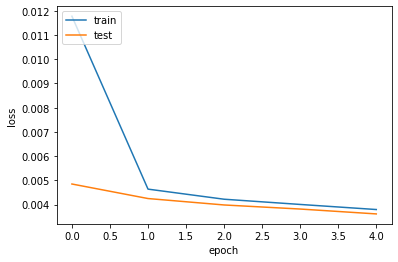

In [21]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])

In [22]:
from tensorflow.keras.losses import MeanSquaredError

y_true = x_test
y_pred = model.predict(x_test_blured)

mse = MeanSquaredError()
mse(y_true, y_pred).numpy()

#0.0023

#0.0041738243220982366
#0.004219622105503972
#0.00404854369862134
#0.003909846398674108
#0.00379532259022029
#0.003393252

0.0036343555